# CS6140 Final Project Proposal: Walkability Index
### Team Members: James Fan, James Florez, Dominic Cauteruccio, Sara Spasojevic


## Step 0: Notebook Prep


In [2]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set display options
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", 40)

# Set global random state
random_state = 1

## Step 1: Data Preprocessing and Analysis

#### Load Data

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_url = "https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv"
raw_df = pd.read_csv(data_url, sep=",", header=0)
raw_df.head()



,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,CBSA_Name,CBSA_POP,CBSA_EMP,CBSA_WRK,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,...,D4E,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
0,1,4.811300e+11,4.811300e+11,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,73.595028,0.0,73.595028,73.595028,1202,460.0,...,0.003602,433601,303660,135362,53504,0.000398,0.785893,0.000358,0.841299,0.000525,0.184697,0.000476,0.137707,6,14,15,17,14.000000,3110.360820,297836.0831
1,2,4.811300e+11,4.811300e+11,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,119.829909,0.0,119.829909,119.214200,710,409.0,...,0.006099,386504,272135,236885,90089,0.000355,0.700531,0.000321,0.753958,0.000919,0.323221,0.000801,0.231868,3,10,12,14,10.833333,3519.469110,484945.1466
2,3,4.811300e+11,4.811300e+11,48,113,7825,3,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,26.367053,0.0,26.367053,26.367050,737,365.0,...,0.004071,404573,288925,230587,82815,0.000371,0.733281,0.000340,0.800475,0.000894,0.314628,0.000736,0.213146,1,1,7,17,8.333333,1697.091802,106705.9281
3,4,4.811300e+11,4.811300e+11,48,113,7824,1,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,119.060687,0.0,119.060687,119.060687,904,384.0,...,0.007378,423099,298058,168433,79657,0.000388,0.766859,0.000351,0.825778,0.000653,0.229821,0.000708,0.205018,16,10,17,17,15.666667,2922.609204,481828.4303
4,5,4.811300e+11,4.811300e+11,48,113,7824,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,169.927211,0.0,169.927211,148.742920,948,343.0,...,0.007036,335700,238166,120826,48682,0.000308,0.608450,0.000281,0.659846,0.000469,0.164863,0.000433,0.125296,4,7,11,14,10.166667,3731.971773,687684.7752


After examining the description of each feature in the dataset's pdf, we have decided that we want to keep the following features. The goal of the project is to use the environmental and socioeconomic factors to predict the walkability score, and explore how those would affect it. In accordance with that, we have decided not to use the features already used to come up with the existing walkability score formula. 

A lot of features were followed by the percentage representation of that feature in the area, which after some exploration, has shown to be the better approach (ie. auto own feature).

In [5]:
columns = ['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'Pct_AO0',\
           'Pct_AO1', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', \
           'R_HiWageWk', 'TotEmp', 'E5_Ret', 'E5_Off', 'E5_Ind', 'E5_Svc', 'E5_Ent', \
           'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', \
           'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', 'D5AR', \
           'D5AE', 'D5BR', 'D5BE', 'NatWalkInd',]

df = raw_df[columns]
df.shape

(220740, 35)

#### Describe Data

In [6]:
# get column types
df.dtypes

Ac_Total       float64
Ac_Water       float64
Ac_Land        float64
Ac_Unpr        float64
TotPop           int64
CountHU        float64
HH             float64
P_WrkAge       float64
Pct_AO0        float64
Pct_AO1        float64
Pct_AO2p       float64
Workers          int64
R_LowWageWk      int64
R_MedWageWk      int64
R_HiWageWk       int64
TotEmp           int64
E5_Ret           int64
E5_Off           int64
E5_Ind           int64
E5_Svc           int64
E5_Ent           int64
E_LowWageWk      int64
E_MedWageWk      int64
E_HiWageWk       int64
D1A            float64
D1B            float64
D1C            float64
D1D            float64
D2C_TRPMX2     float64
D2R_WRKEMP     float64
D5AR             int64
D5AE             int64
D5BR             int64
D5BE             int64
NatWalkInd     float64
dtype: object

In [7]:
# describe numeric variables
df.describe()

,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,Workers,R_LowWageWk,R_MedWageWk,R_HiWageWk,TotEmp,E5_Ret,E5_Off,E5_Ind,E5_Svc,E5_Ent,E_LowWageWk,E_MedWageWk,E_HiWageWk,D1A,D1B,D1C,D1D,D2C_TRPMX2,D2R_WRKEMP,D5AR,D5AE,D5BR,D5BE,NatWalkInd
count,2.207400e+05,2.207400e+05,2.207400e+05,2.207400e+05,220740.000000,220465.000000,220465.000000,220740.00000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220469.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,2.207400e+05,220740.000000,2.207400e+05,2.207400e+05,220740.000000
mean,1.103567e+04,7.807248e+02,1.025494e+04,6.831866e+03,1479.863804,626.014628,548.785989,0.59474,0.092874,0.328227,0.569939,637.816753,146.015815,210.235820,281.565117,639.106487,71.185426,87.631625,151.342099,256.042117,72.905219,146.436255,211.019806,281.650426,4.530262,10.428739,3.773612,8.298313,0.491936,0.425024,1.030618e+05,88536.521695,4.413897e+04,1.520207e+02,9.541628
std,1.588982e+05,2.683978e+04,1.488759e+05,4.367872e+04,987.862242,383.714541,339.039272,0.10610,0.136020,0.151983,0.219775,420.866297,90.312972,135.076957,235.370220,2021.360339,227.948218,683.346046,638.944327,992.979149,358.621166,357.650538,550.314594,1273.883797,13.881912,29.129998,46.392440,50.474119,0.234264,0.306272,1.531004e+05,130263.329763,3.854568e+05,2.038590e+05,4.373952
min,1.096136e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-9.999900e+04,-9.999900e+04,1.000000
25%,1.231824e+02,0.000000e+00,1.200676e+02,1.143877e+02,889.000000,392.000000,341.000000,0.54400,0.010381,0.217391,0.432056,384.000000,91.000000,127.000000,136.000000,69.000000,0.000000,0.000000,5.000000,17.000000,0.000000,19.000000,25.000000,17.000000,0.300543,0.714507,0.075862,0.531225,0.326433,0.153326,9.260000e+03,9150.000000,-9.999900e+04,-9.999900e+04,5.833333
50%,3.394946e+02,0.000000e+00,3.229443e+02,3.044386e+02,1265.000000,544.000000,476.000000,0.59500,0.044010,0.319574,0.603448,550.000000,128.000000,183.000000,226.000000,200.000000,11.000000,7.000000,24.000000,63.000000,11.000000,54.000000,72.000000,59.000000,1.845611,4.320753,0.533630,3.140893,0.509930,0.389110,4.273400e+04,38964.000000,-9.999900e+04,-9.999900e+04,9.166667
75%,2.325991e+03,1.973606e+01,2.141221e+03,1.950541e+03,1816.000000,764.000000,673.000000,0.64800,0.115529,0.429613,0.737535,792.000000,181.000000,263.000000,362.000000,548.000000,51.000000,34.000000,86.000000,195.000000,60.000000,145.000000,198.000000,181.000000,4.163989,10.136846,2.157909,6.834936,0.685096,0.684399,1.251635e+05,105586.000000,4.775125e+04,3.174650e+04,13.166667
max,4.055649e+07,5.455459e+06,3.914039e+07,5.074313e+06,55407.000000,26436.000000,21337.000000,1.00000,1.000000,1.000000,1.000000,19255.000000,3639.000000,5014.000000,10683.000000,266101.000000,30444.000000,110844.000000,47840.000000,137775.000000,92976.000000,38083.000000,49946.000000,204309.000000,1481.257220,3133.578265,14032.760640,14111.660620,0.991059,1.000000,1.220602e+06,964355.000000,6.963967e+06,2.697797e+06,20.000000


In [8]:
# show null values
print(df.isnull().sum().sort_values(ascending=False))

CountHU        275
HH             275
D1A            271
Ac_Total         0
D1D              0
E_LowWageWk      0
E_MedWageWk      0
E_HiWageWk       0
D1B              0
D1C              0
D2C_TRPMX2       0
E5_Svc           0
D2R_WRKEMP       0
D5AR             0
D5AE             0
D5BR             0
D5BE             0
E5_Ent           0
E5_Off           0
E5_Ind           0
Ac_Water         0
E5_Ret           0
TotEmp           0
R_HiWageWk       0
R_MedWageWk      0
R_LowWageWk      0
Workers          0
Pct_AO2p         0
Pct_AO1          0
Pct_AO0          0
P_WrkAge         0
TotPop           0
Ac_Unpr          0
Ac_Land          0
NatWalkInd       0
dtype: int64


In [9]:
# Drop household NaN samples
df = df.dropna(subset=['CountHU'], axis=0)
df = df.dropna(subset=['HH'], axis=0)

# fill the leftover null variables with median
df = df.fillna(df.median())

df.shape


(220465, 35)

# EDA - Univariate Analysis

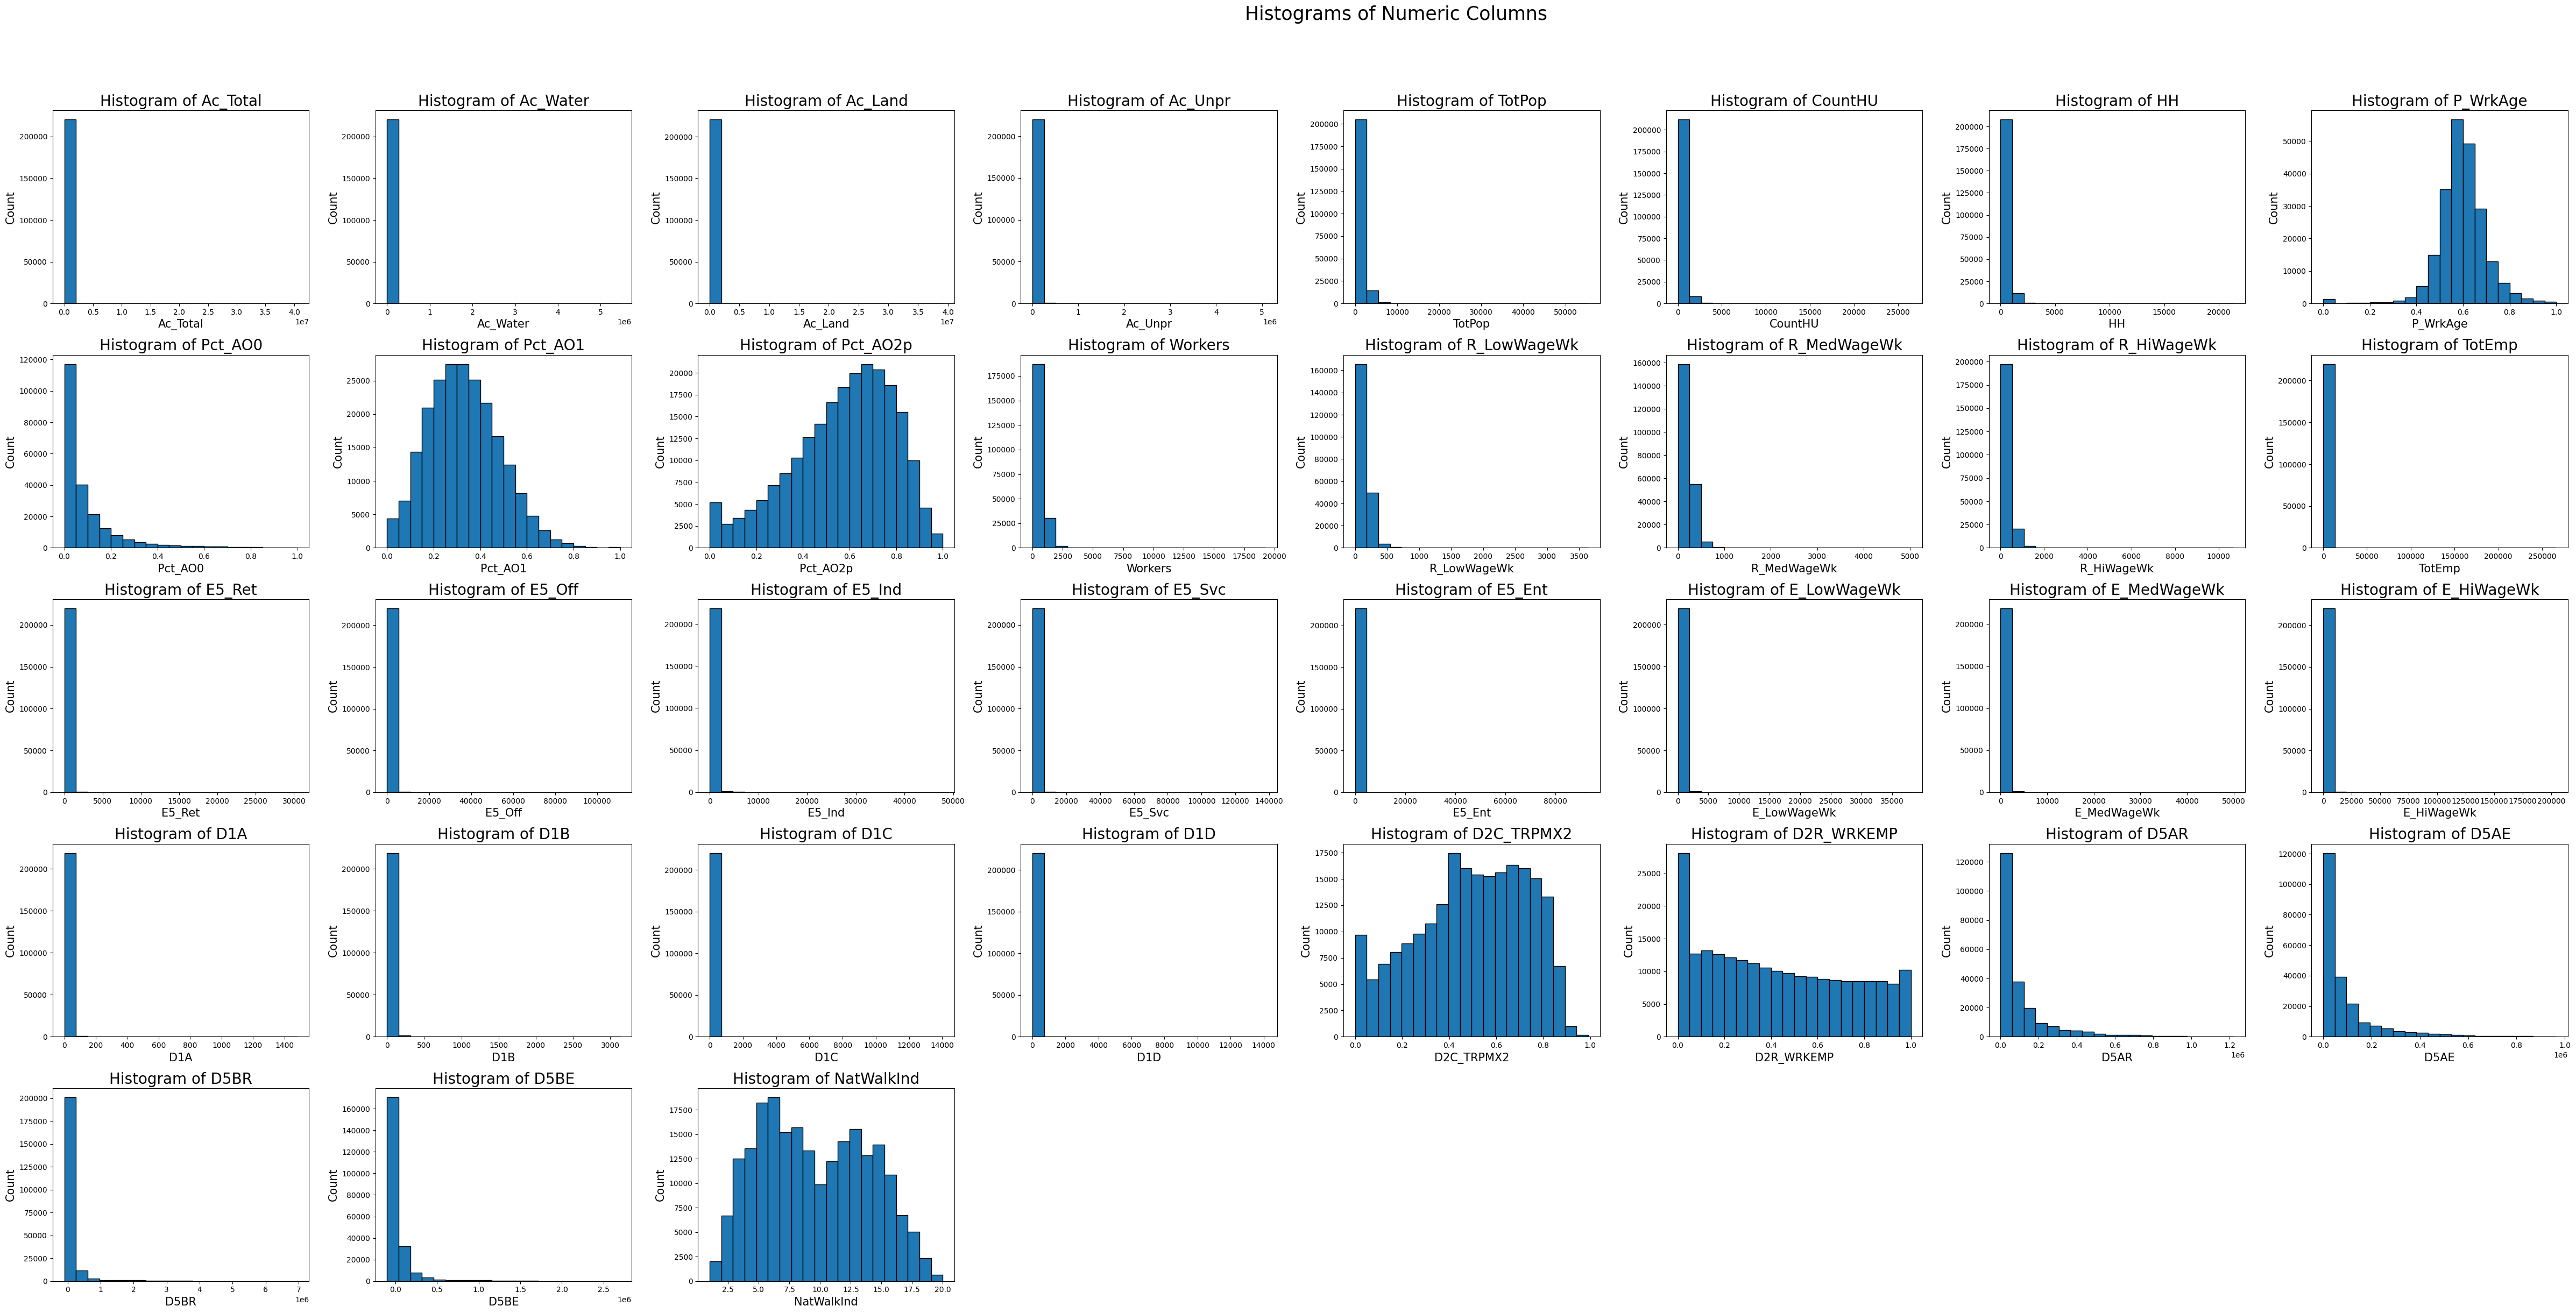

In [10]:
# Univariate Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for selected numeric columns with larger individual plots
plt.figure(figsize=(40, 30))
for i, column in enumerate(df.columns):
    plt.subplot(8, 8, i + 1)
    df[column].hist(bins=20, edgecolor='black', linewidth=1.0, grid=False)
    plt.title(f'Histogram of {column}', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('Count', fontsize=15)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.suptitle('Histograms of Numeric Columns', x=0.65, y=1.25, fontsize=25)
plt.show()


Let's take a look at the correlation matrix.

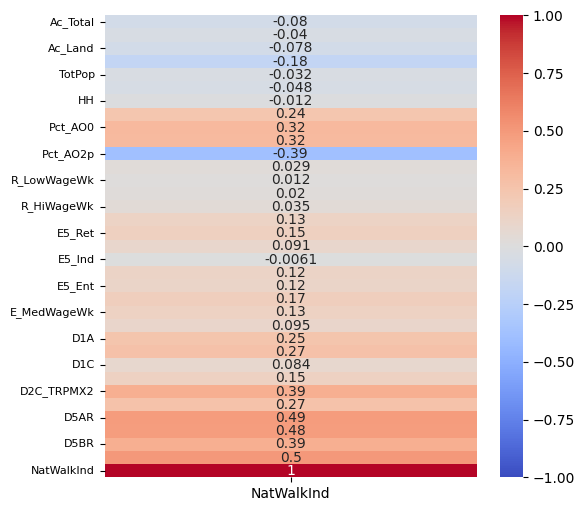

In [11]:
correlation_matrix = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix[['NatWalkInd']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks(fontsize=8)
plt.show()

## Head count per acre

We decided to create a feature that will show the head count per acre.

In [12]:
df[["TotPop", "Ac_Total", "NatWalkInd"]].corr()

,TotPop,Ac_Total,NatWalkInd
TotPop,1.000000,-0.020725,-0.031859
Ac_Total,-0.020725,1.000000,-0.080179
NatWalkInd,-0.031859,-0.080179,1.000000


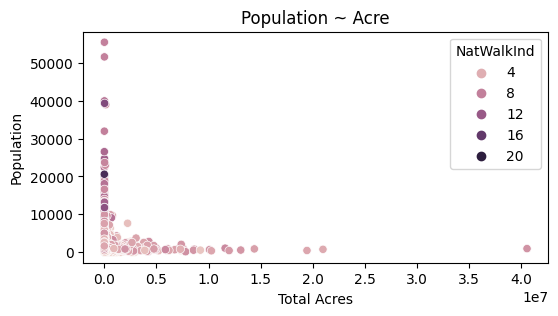

In [13]:
df['Pop_Acre'] = df['TotPop'] / df['Ac_Total']

plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Ac_Total", y="TotPop", hue="NatWalkInd")
plt.title('Population ~ Acre')
plt.xlabel('Total Acres')
plt.ylabel('Population')
plt.show()

After the feature was created, see below impact in the correlation map. It performs much higher than the TotPop.

In [14]:
df[["Pop_Acre", "NatWalkInd"]].corr()

,Pop_Acre,NatWalkInd
Pop_Acre,1.000000,0.307833
NatWalkInd,0.307833,1.000000


## Auto

Looking at the correlation heatmap and the way auto affects the walkability score, we decided to consolidate them to 1 or none, and 2 or more cars, to see how it would affect the score.

In [15]:
df[["Pct_AO0", "Pct_AO1", "Pct_AO2p", "NatWalkInd"]].corr()

,Pct_AO0,Pct_AO1,Pct_AO2p,NatWalkInd
Pct_AO0,1.000000,0.128376,-0.686125,0.322431
Pct_AO1,0.128376,1.000000,-0.695753,0.319058
Pct_AO2p,-0.686125,-0.695753,1.000000,-0.386020
NatWalkInd,0.322431,0.319058,-0.386020,1.000000


In [16]:
df['Pct_A_OneNone'] = df['Pct_AO0'] + df['Pct_AO1']

df.drop(['Pct_AO0', 'Pct_AO1'], axis=1, inplace=True)

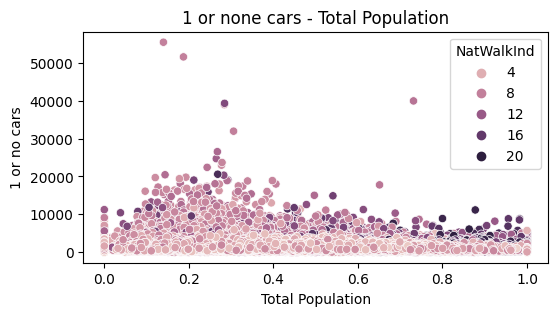

In [17]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Pct_A_OneNone", y="TotPop", hue="NatWalkInd")
plt.title('1 or none cars - Total Population')
plt.xlabel('Total Population')
plt.ylabel('1 or no cars')
plt.show()

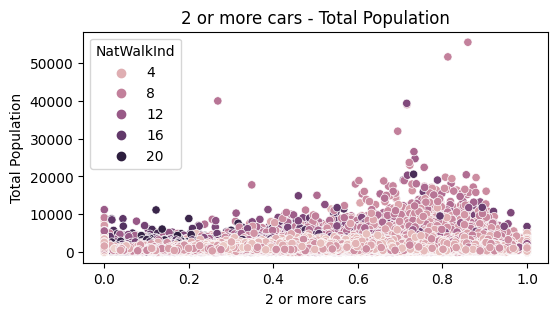

In [18]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Pct_AO2p", y="TotPop", hue="NatWalkInd")
plt.title('2 or more cars - Total Population')
plt.xlabel('2 or more cars')
plt.ylabel('Total Population')
plt.show()

Let's look at the correlation scores after this feature was created.

In [19]:
df[["Pct_A_OneNone", "Pct_AO2p", "NatWalkInd"]].corr()

,Pct_A_OneNone,Pct_AO2p,NatWalkInd
Pct_A_OneNone,1.000000,-0.91918,0.426415
Pct_AO2p,-0.919180,1.00000,-0.386020
NatWalkInd,0.426415,-0.38602,1.000000


## Household

Observe that we have features CountHU and HH, which are total number of households in that sector, and number of households occupied, respectively.
We chose to create one variable "Occupied" that will show the percentage of the occupied households.

In [20]:
df['Occupied'] = df.apply(lambda row: (row['HH'] / row['CountHU']) * 100 if row['CountHU'] != 0 else 100, axis=1)
df.drop(["CountHU", "HH"], axis=1, inplace=True)

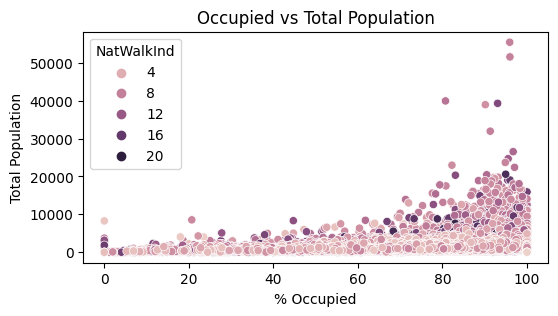

In [21]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Occupied", y="TotPop", hue="NatWalkInd")
plt.title('Occupied vs Total Population')
plt.xlabel('% Occupied')
plt.ylabel('Total Population')
plt.show()

## Wage - residents

In [22]:
df['Pct_HighWage_Reside'] = df.apply(lambda row: ((row['R_HiWageWk'])/ row['Workers']) * 100 if row['Workers'] != 0 else 0, axis=1)
df.drop(['R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'Workers'], axis=1, inplace=True)

Let's see if there's a relationship between walkability and percentage of population that earns a high wage in areas that are labeled unwalkable (> 15). 

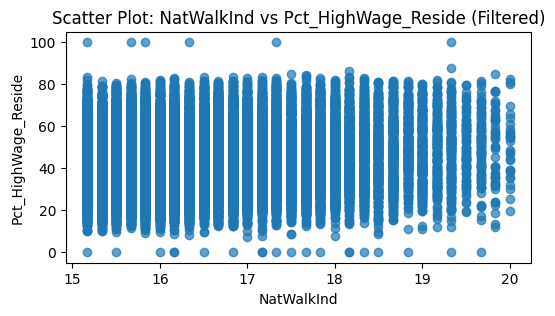

In [23]:
unwalkable = df[df['NatWalkInd'] > 15]

plt.figure(figsize=(6, 3))
plt.scatter(unwalkable['NatWalkInd'], unwalkable['Pct_HighWage_Reside'], alpha=0.7)
plt.title('Scatter Plot: NatWalkInd vs Pct_HighWage_Reside (Filtered)')
plt.xlabel('NatWalkInd')
plt.ylabel('Pct_HighWage_Reside')
plt.show()

From the graph we cannot observe any particular relationship, and seems like with only very high unwalkable scores (19, 20) increase the percentage of population with higher income.

See the correlation with walkability index below:

In [24]:
df[["Pct_HighWage_Reside", "NatWalkInd"]].corr()

,Pct_HighWage_Reside,NatWalkInd
Pct_HighWage_Reside,1.000000,0.112913
NatWalkInd,0.112913,1.000000


## E5

Taking a look at types of jobs in the area, and correlation map, we've decided to drop the Industrial, as they don't have a high predicting contribution. The highest seems to be retail, service and entertainment.

In [25]:
df['Pct_Retail'] = df.apply(lambda row: ((row['E5_Ret'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df['Pct_Service'] = df.apply(lambda row: ((row['E5_Svc'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df['Pct_Ent'] = df.apply(lambda row: ((row['E5_Ent'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df.drop(['E5_Ret', 'E5_Off', 'E5_Ind','E5_Svc', 'E5_Ent'], axis=1, inplace=True)

Let's take a look at the correlation matrix after all the new features were made.

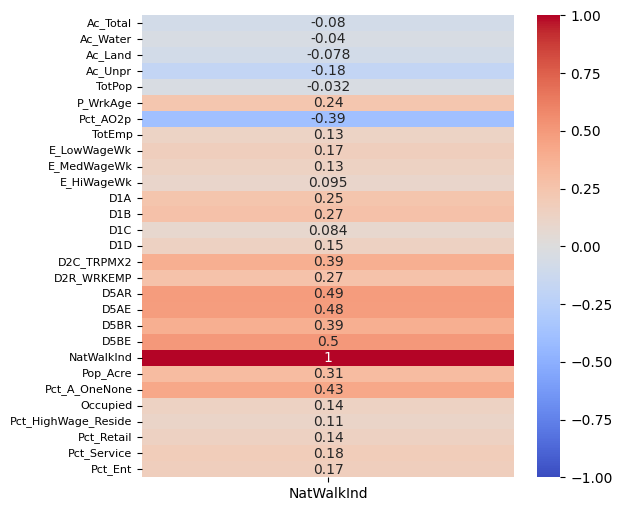

In [26]:
correlation_matrix = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix[['NatWalkInd']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks(fontsize=8)
plt.show()

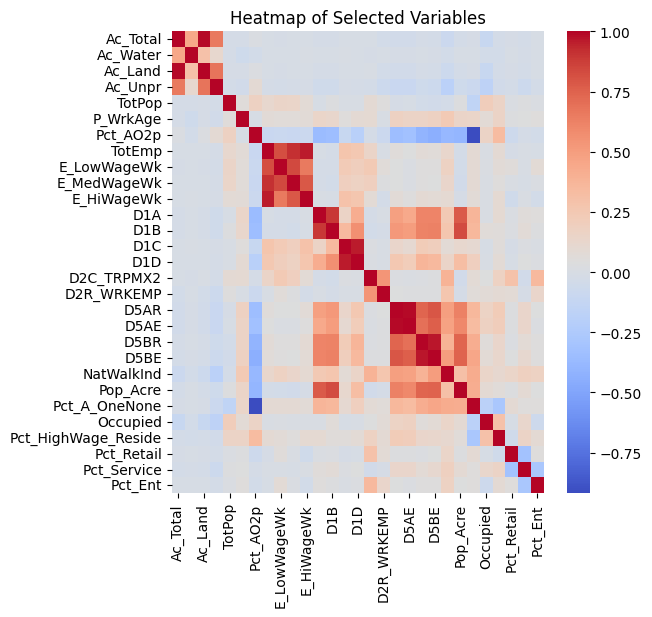

In [27]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Selected Variables')
plt.show()

## Step 2: Model Creation

#### Split and Standardize the Dataset

In [28]:
# Function that splits dataset - K-fold 
def create_splits(X, y):
    X_train_splits = []
    X_test_splits = []
    y_train_splits = []
    y_test_splits = []

    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(X):
        # set new train/test groups
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # append to lists for use later
        X_train_splits.append(X_train)
        X_test_splits.append(X_test)
        y_train_splits.append(y_train)
        y_test_splits.append(y_test)

    return X_train_splits, X_test_splits, y_train_splits, y_test_splits

In [30]:
# Split data into X and Y
y = df["NatWalkInd"]
X = df.drop("NatWalkInd", axis=1)

#### Define Hyperparameters and Initialize Models

In [31]:
# Linear Regression
linear = linear_model.LinearRegression()

# Ridge Regression
ridge_alpha = 1.0
ridge = linear_model.Ridge(alpha=ridge_alpha)

# Random Forest
rf_estimators = 10
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, random_state=random_state)

# Support Vector Machine (SVM)
svm_kernel = "rbf"
svm_c = 3
svm_max_iter = 2000
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, max_iter=svm_max_iter)

# Multi-Layer Perceptron (MLP)
mlp_num_layers = 5
mlp_num_neurons = 5
mlp_alpha = 0.0001
mlp_learning_rate_init = 0.001
mlp_max_iter = 1000
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    learning_rate_init=mlp_learning_rate_init,
    max_iter=mlp_max_iter,
    random_state=random_state)

## Step 3: Model Training and Evaluation

In [41]:
# Define a function to train and evaluate a regression model

def model_train_and_eval_single(model, X_train, X_test, y_train, y_test, model_name):
  # Given a regression model and data, this trains the model, plots the coefficients, and evaluates the performance.

  # Train the model with training data
  model.fit(X_train, y_train)

  # Make predicitions on test data
  y_pred = model.predict(X_test)

  # Plot the weights of the model
  if (model_name in ["Linear", "Ridge"]):
    plt.plot(X.columns, model.coef_)
    plt.title(f"Coefficients of {model_name} Regression Model")
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

  # Evaluate performance of the model
  mse = metrics.mean_squared_error(y_test, y_pred)
  r2 = metrics.r2_score(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")
  print(f"R-squared: {r2}")

  return mse, r2


# Initialize variable to hold MSE and R^2 results
mse_list = []
r2_list = []

In [43]:
def model_train_and_eval(model, X, y, k_fold=True, standardization=True, model_name=None):
    if k_fold:
        kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        mse_list = []
        r2_list = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if standardization:
                scaler = preprocessing.StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            mse, r2 = model_train_and_eval_single(model, X_train, X_test, y_train, y_test, model_name)
            mse_list.append(mse)
            r2_list.append(r2)

        return mse_list, r2_list

    else:
        if standardization:
            scaler = preprocessing.StandardScaler()
            X = scaler.fit_transform(X)

        # Use an 80-20 train-test split
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

        return model_train_and_eval_single(model, X_train, X_test, y_train, y_test, model_name)

#### Linear Regression

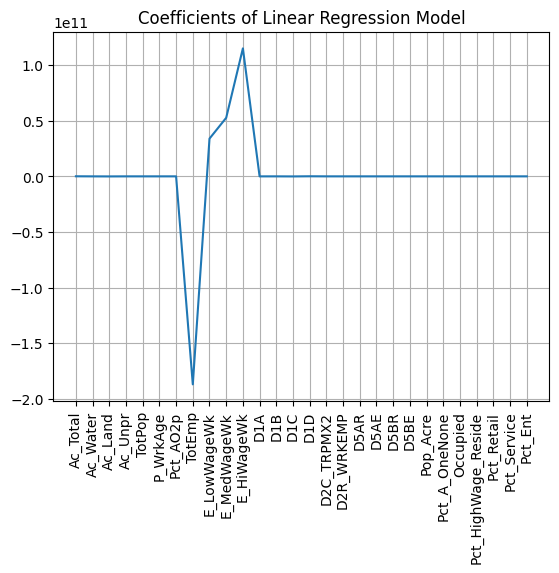

Mean Squared Error: 7.26149941431891
R-squared: 0.6181618535788431


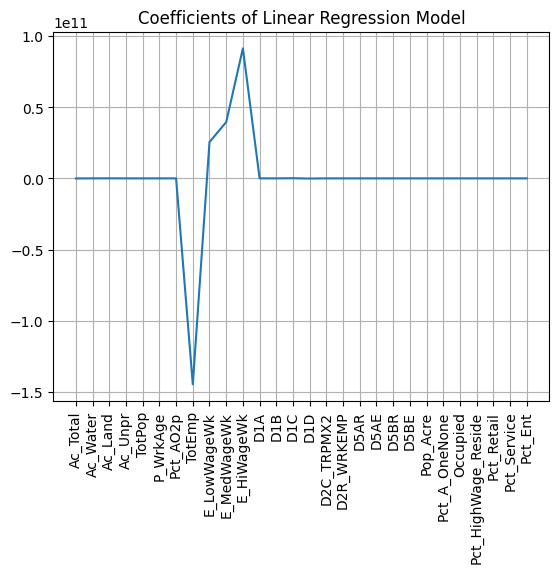

Mean Squared Error: 7.360824530397647
R-squared: 0.6169014250297598


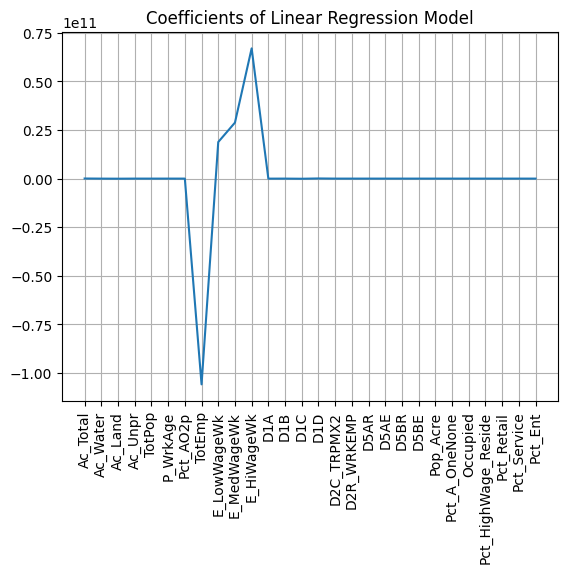

Mean Squared Error: 7.301109300199209
R-squared: 0.6131237949492645


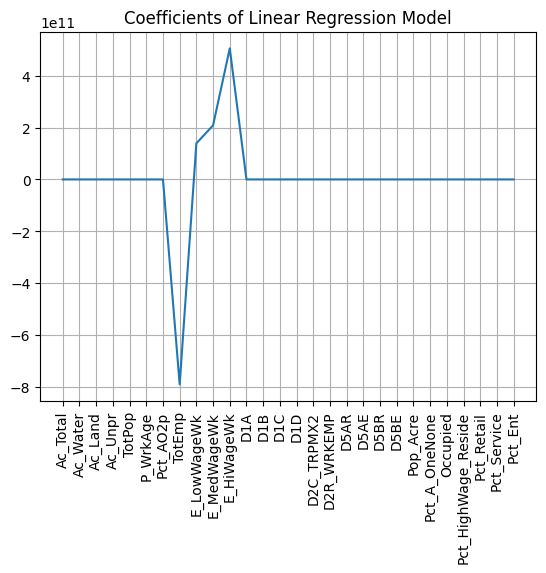

Mean Squared Error: 7.349924625895048
R-squared: 0.618015909758733


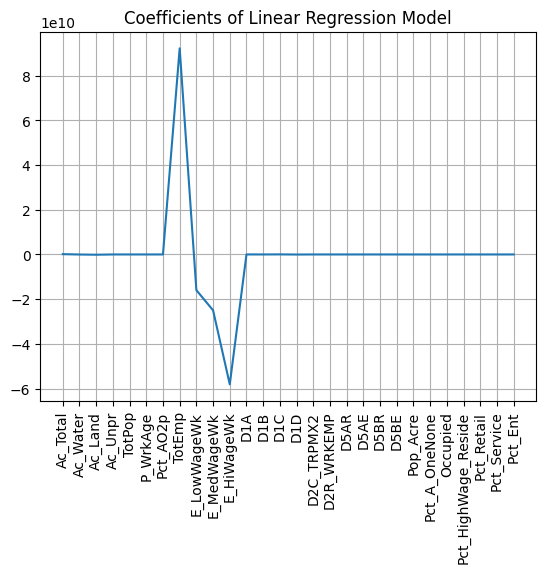

Mean Squared Error: 7.340549905962689
R-squared: 0.6131556623557938


In [47]:
linear_mse_list, linear_r2_list = model_train_and_eval(linear, X, y, model_name="Linear")

mse_list.append(np.mean(linear_mse_list))
r2_list.append(np.mean(linear_r2_list))

#### Ridge Regression

Iteration: 1


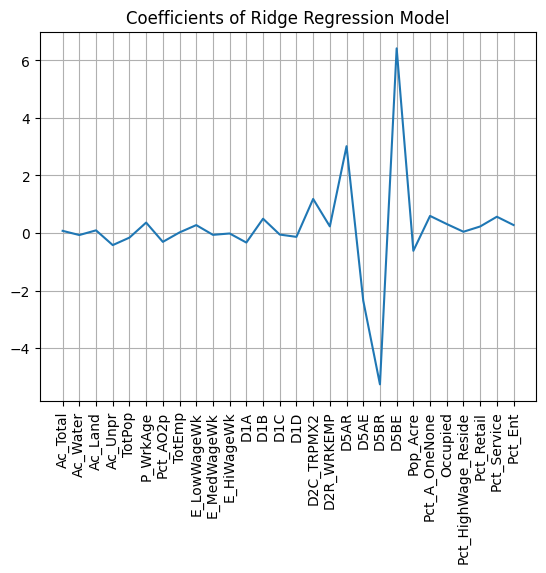

Mean Squared Error: 7.365180093448363
R-squared: 0.613508090847561
Iteration: 2


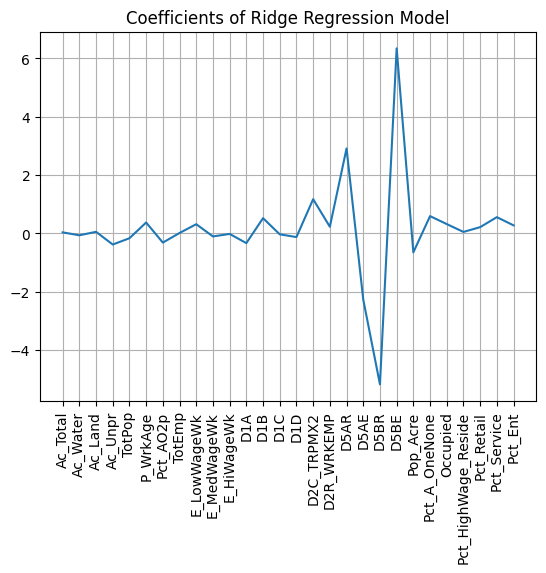

Mean Squared Error: 7.352295975291177
R-squared: 0.616140970133755
Iteration: 3


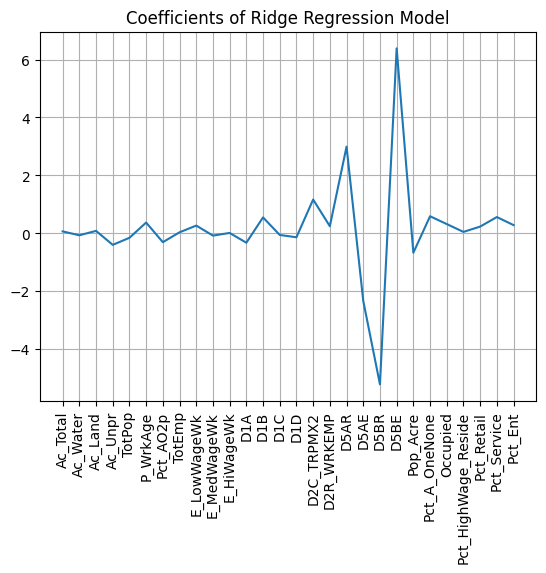

Mean Squared Error: 7.333575679481541
R-squared: 0.6155012472642118
Iteration: 4


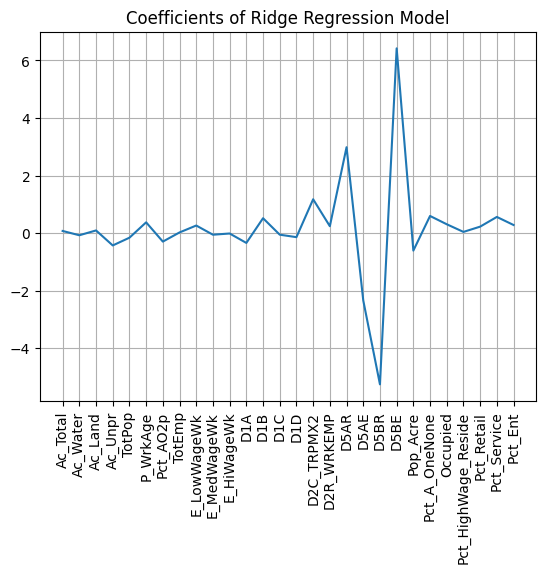

Mean Squared Error: 7.319538742539052
R-squared: 0.6155267694924873
Iteration: 5


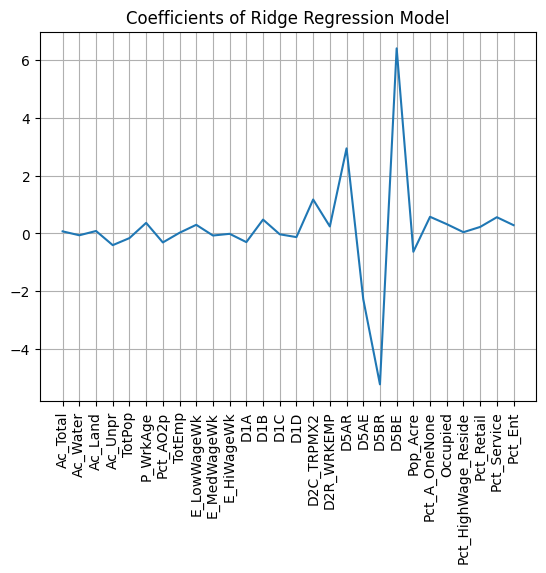

Mean Squared Error: 7.2138563661693045
R-squared: 0.6202909144570323


In [34]:
ridge_mse_list = []
ridge_r2_list = []
for i in range(len(X_train_std_splits)):
  print(f"Iteration: {i+1}")
  ridge_mse, ridge_r2 = model_train_and_eval(ridge, X_train_std_splits[i], X_test_std_splits[i], \
                                               y_train_splits[i], y_test_splits[i], "Ridge")
  ridge_mse_list.append(ridge_mse)
  ridge_r2_list.append(ridge_r2)


mse_list.append(np.mean(ridge_mse_list))
r2_list.append(np.mean(ridge_r2_list))

#### Random Forest

In [35]:
rf_mse_list = []
rf_r2_list = []
for i in range(len(X_train_std_splits)):
  print(f"Iteration: {i+1}")
  rf_mse, rf_r2 = model_train_and_eval(random_forest, X_train_std_splits[i], X_test_std_splits[i], \
                                               y_train_splits[i], y_test_splits[i], "Random Forest")
  rf_mse_list.append(rf_mse)
  rf_r2_list.append(rf_r2)


mse_list.append(np.mean(rf_mse_list))
r2_list.append(np.mean(rf_r2_list))

#rf_mse, rf_r2 = model_train_and_eval(random_forest, X_train_std, X_test_std, y_train, y_test, "Random Forest")
#mse_list.append(rf_mse)
#r2_list.append(rf_r2)

Iteration: 1
Mean Squared Error: 1.357305297859933
R-squared: 0.9287746519139093
Iteration: 2
Mean Squared Error: 1.3756317203426347
R-squared: 0.9281790804670312
Iteration: 3
Mean Squared Error: 1.3512015323501192
R-squared: 0.9291566179187455
Iteration: 4
Mean Squared Error: 1.335399402046284
R-squared: 0.9298555086349014
Iteration: 5
Mean Squared Error: 1.347770217986232
R-squared: 0.9290586655712203


#### Support Vector Machine

In [36]:
svm_mse_list = []
svm_r2_list = []
for i in range(len(X_train_std_splits)):
  print(f"Iteration: {i+1}")
  svm_mse, svm_r2 = model_train_and_eval(svm_model, X_train_std_splits[i], X_test_std_splits[i], \
                                               y_train_splits[i], y_test_splits[i], "SVM")
  svm_mse_list.append(svm_mse)
  svm_r2_list.append(svm_r2)


mse_list.append(np.mean(svm_mse_list))
r2_list.append(np.mean(svm_r2_list))


#svm_mse, svm_r2 = model_train_and_eval(svm_model, X_train_std, X_test_std, y_train, y_test, "SVM")
#mse_list.append(svm_mse)
#r2_list.append(svm_r2)

Iteration: 1


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.205036726650247
R-squared: 0.7268628117483357
Iteration: 2


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 4.420757361767914
R-squared: 0.7691948694849589
Iteration: 3


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 3.577948514866979
R-squared: 0.8124084619228369
Iteration: 4


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 6.096390875724301
R-squared: 0.6797750272426076
Iteration: 5


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 4.0784739903232845
R-squared: 0.785325136699556


#### Multi-Layer Perceptron

In [37]:
mlp_mse_list = []
mlp_r2_list = []
for i in range(len(X_train_std_splits)):
  print(f"Iteration: {i+1}")
  mlp_mse, mlp_r2 = model_train_and_eval(mlp, X_train_std_splits[i], X_test_std_splits[i], \
                                               y_train_splits[i], y_test_splits[i], "MLP")
  mlp_mse_list.append(mlp_mse)
  mlp_r2_list.append(mlp_r2)


mse_list.append(np.mean(mlp_mse_list))
r2_list.append(np.mean(mlp_r2_list))



#mlp_mse, mlp_r2 = model_train_and_eval(mlp, X_train_std, X_test_std, y_train, y_test, "MLP")
#mse_list.append(mlp_mse)
#r2_list.append(mlp_r2)

Iteration: 1
Mean Squared Error: 1.5140220943489675
R-squared: 0.9205508511238675
Iteration: 2
Mean Squared Error: 1.5390674407132834
R-squared: 0.9196461980480147
Iteration: 3
Mean Squared Error: 1.4878584071338459
R-squared: 0.9219917095297687
Iteration: 4
Mean Squared Error: 1.4923421505382746
R-squared: 0.9216117807662635
Iteration: 5
Mean Squared Error: 1.586260499095398
R-squared: 0.9165054732210745


#### Plot Performance of Different Models

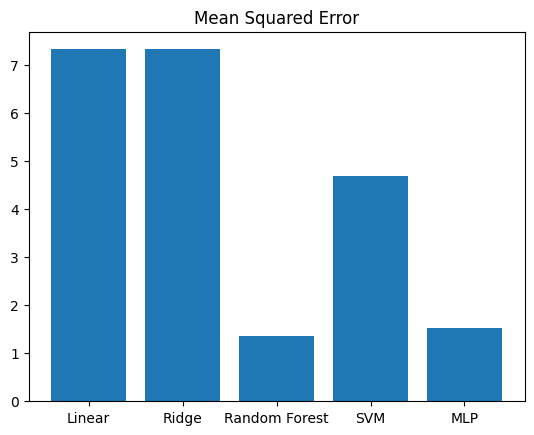

In [38]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], mse_list)
plt.title("Mean Squared Error")
plt.show()

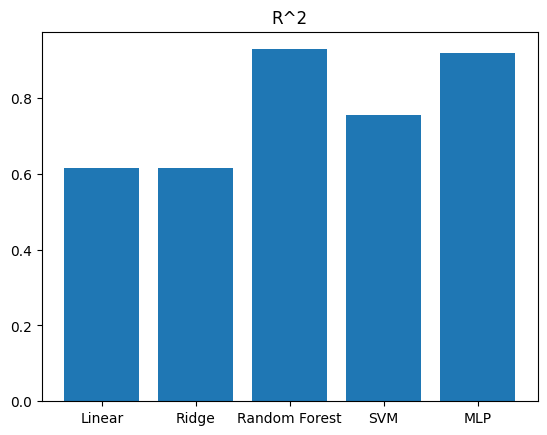

In [39]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], r2_list)
plt.title("R^2")
plt.show()

## Step X?: Principal Component Analysis

#### Compare the performance of the strongest model with and without PCA

In [40]:
# PCA on the training set
pca = decomposition.PCA()  # Specify the number of components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(num_components) + 1, explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

NameError: name 'X_train_std' is not defined